# New York AirBnB Data
Using the NewYork data - useful facts about the data:

Business Questions (Business Understanding)
<b><li>What are the most common type of  properties in NewYork available for renting?What are the availabilities of the properties throughout the year?</li></b> 

<b><li>What is the average pricing of the properties available for renting?Are there any seasonal spiking in the prices of the properties?</li></b> 

<b><li>What streets have the highest and lowest property prices? 
Where to Invest a Property in NewYork to get maximum returns from Airbnb?</li></b> 

<b><li>Can we use listing details to predict property prices?What factors determine the price of your home?</li></b> 

First, let's read in the necessary libraries and datasets.

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [137]:
listings = pd.read_csv('listings.csv')
calendar = pd.read_csv('calendar.csv')

Little data wrangling and cleaning here, to prepare the data for analysis 

In [138]:
#droping columns which are not usefull in  analysing the respective questions.
listings = listings.drop(['transit', 'neighborhood_overview', 'listing_url', 'summary', 'space', 'description', 
                          'access', 'interaction', 'house_rules', 'thumbnail_url','medium_url','picture_url', 
                          'xl_picture_url', 'host_url', 'host_name', 'host_about', 'host_thumbnail_url', 'host_verifications',
                          'calendar_updated'], axis = 1)

In [139]:
#removing columns which has only one value as that column would be not usefull for analysis 
for col in listings:
    if listings[col].value_counts().count() <= 1:
        listings = listings.drop(col, axis = 1)

In [140]:
#dropping the columns which have 60% of its values missing
for col in listings:
        percentage = listings[col].isna().sum() / listings.shape[0] * 100
        if percentage > 60:
            listings = listings.drop(col, axis = 1)

In [141]:
#Replacing Nan values with 0
listings.fillna(0, inplace = True)
calendar.fillna(0, inplace = True)

In [142]:
listings.price.dtype

dtype('O')

In [143]:
calendar.price.dtype

dtype('O')

In [144]:
#converting price into float
listings['price'] = listings['price'].apply(lambda x: float(str(x).replace('$', '').replace(',', '')))
calendar['price'] = calendar['price'].apply(lambda x: float(str(x).replace('$', '').replace(',', '')))

In [145]:
calendar['date'].head()

0    2019-09-13
1    2019-09-13
2    2019-09-14
3    2019-09-15
4    2019-09-16
Name: date, dtype: object

In [146]:
#adding a new column Year-Month to do the monthly analysis of the data
calendar['Year-Month'] = calendar['date'].apply(lambda x:(str(x).replace(x, x[0:7])))
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,Year-Month
0,9668,2019-09-13,f,51.0,$51.00,3.0,365.0,2019-09
1,26969,2019-09-13,f,350.0,$350.00,3.0,33.0,2019-09
2,26969,2019-09-14,f,350.0,$350.00,3.0,33.0,2019-09
3,26969,2019-09-15,f,350.0,$350.00,3.0,33.0,2019-09
4,26969,2019-09-16,f,350.0,$350.00,3.0,33.0,2019-09


In [147]:
calendar.available.dtype

dtype('O')

In [148]:
#converting the column "available" into boolean for performing operations
calendar.available.replace('f', False, inplace = True)
calendar.available.replace('t', True, inplace = True)
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,Year-Month
0,9668,2019-09-13,False,51.0,$51.00,3.0,365.0,2019-09
1,26969,2019-09-13,False,350.0,$350.00,3.0,33.0,2019-09
2,26969,2019-09-14,False,350.0,$350.00,3.0,33.0,2019-09
3,26969,2019-09-15,False,350.0,$350.00,3.0,33.0,2019-09
4,26969,2019-09-16,False,350.0,$350.00,3.0,33.0,2019-09


<h1><b>1)What are the most common type of properties in NewYork available for renting?What are the availabilities of the properties throughout the year?</b></h1>

In [149]:
#grouping the property types according to their frequency
common_properties = listings.groupby('property_type').count()['id'].reset_index().sort_values(by='id',ascending=False).head(9)
common_properties

,property_type,id
1,Apartment,38144
22,House,3944
33,Townhouse,1624
13,Condominium,1512
25,Loft,1375
29,Serviced apartment,437
18,Guest suite,382
21,Hotel,219
5,Boutique hotel,214


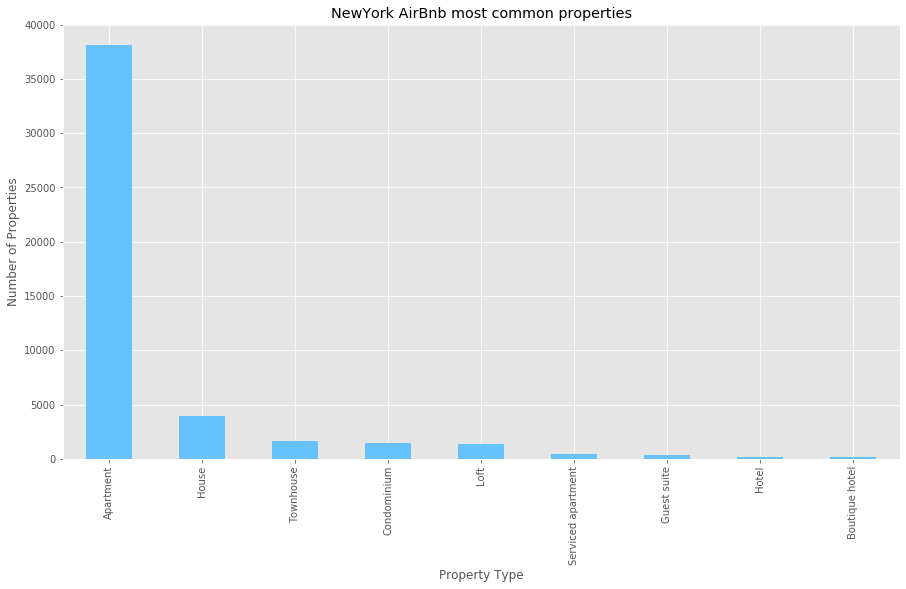

In [150]:
#plotting the data of the table above
plt.style.use('ggplot');

common_properties.plot(kind='bar', 
           x='property_type',
           y='id',
           color = '#66c2ff', 
           figsize =(15,8), 
           title = "NewYork AirBnb most common properties", 
           legend = False);
plt.xlabel('Property Type');
plt.ylabel('Number of Properties');

In [151]:
listings.property_type.value_counts().count()

36

It can be concluded that property type also plays an important factor. Not surprisingly, Apartment and houses take up an overwhelming majority of all listings, followed by townhouse and Condominium.There are total 36 types of properties available for renting in NewYork of which the properties displayed in the graph above have the maximum frequency.

In [152]:
#grouping the availibilty of the properties according to the months.
property_availability = calendar.groupby('Year-Month').mean()['available'].reset_index()
property_availability

,Year-Month,available
0,2019-09,0.136140
1,2019-10,0.251666
2,2019-11,0.368903
3,2019-12,0.347781
4,2020-01,0.385394
5,2020-02,0.400951
6,2020-03,0.339227
7,2020-04,0.301791
8,2020-05,0.306313
9,2020-06,0.293220


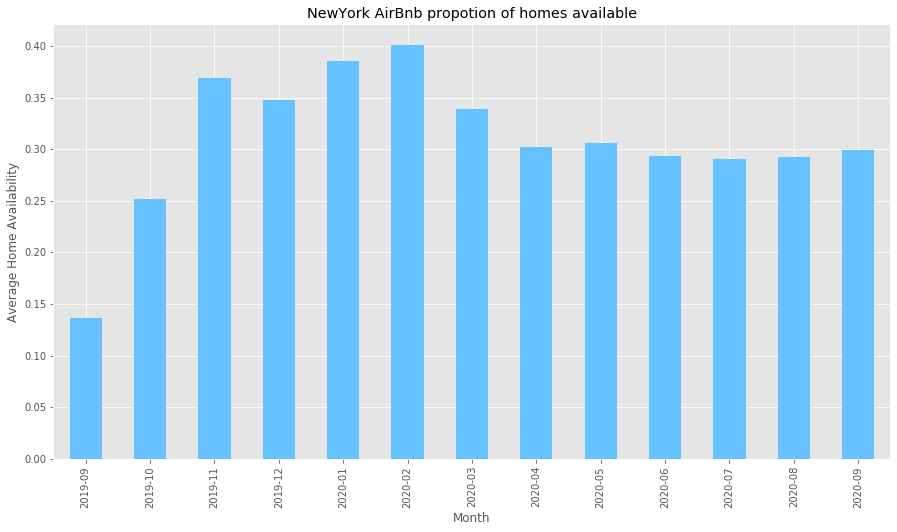

In [153]:
#plotting the data for the above table
property_availability.plot(kind='bar', 
           x='Year-Month',
           y='available',
           color = '#66c2ff', 
           figsize =(15,8), 
           title = "NewYork AirBnb propotion of homes available", 
           legend = False);
plt.xlabel('Month');
plt.ylabel('Average Home Availability');

The highest availability for homes will be in the Febraury 2020 while the lowest availability was observed in the September 2019.You can observe rest of the trends in the availability from the chart above

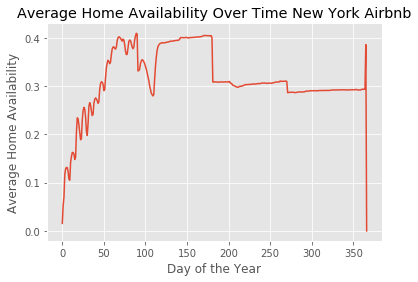

In [154]:
#Analysing the home availability on each single day of the year
homes_perday = calendar.groupby('date').mean()['available'].reset_index()
plt.plot(homes_perday['available']);
plt.title('Average Home Availability Over Time New York Airbnb');
plt.xlabel('Day of the Year');
plt.ylabel('Average Home Availability');

Above plot shows the detail analysis of the home availability throughout the year.Day 1 is at September-12 2019 and Day 365 is at September-12 2020 in the above graph

<b><h1>2)What is the average pricing of the properties available for renting?Are there any seasonal spiking in the prices of the properties?</b></h1>

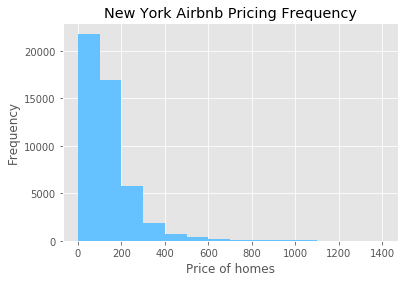

In [155]:
#plotting frequency of the pricing in the data
plt.hist(data = listings , x='price',color = '#66c2ff',  bins=np.arange(0,1500,100));
plt.title('New York Airbnb Pricing Frequency');
plt.xlabel('Price of homes');
plt.ylabel('Frequency');

Most of the pricing of the homes falls within $0-200.This is a proper left scewed left distribution where most the pricing are falls in low limits.

In [156]:
#grouping the prices according to the months to analyse seasonal spiking
seasonal_prices = calendar.groupby('Year-Month').mean()['price'].reset_index()
seasonal_prices

,Year-Month,price
0,2019-09,154.102058
1,2019-10,155.066236
2,2019-11,153.671050
3,2019-12,162.358932
4,2020-01,154.179901
5,2020-02,150.506170
6,2020-03,153.910309
7,2020-04,157.030554
8,2020-05,158.401121
9,2020-06,157.476664


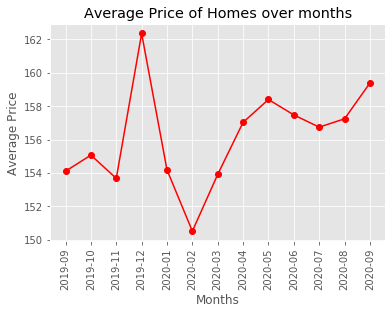

In [157]:
x=seasonal_prices['Year-Month'].tolist()
y=seasonal_prices['price'].tolist()
plt.plot(x,y,'ro-')
plt.ylabel('Average Price')
plt.xlabel('Months')
plt.title('Average Price of Homes over months')
plt.xticks(rotation=90)
plt.show();

The Home prices will be at peak on December2019 and fall lowest on the february2020.There won't be major fluctuation in the prices form April2020 to August2020

In [158]:
#grouping the prices according to the days to analyse seasonal spiking
seasonal_prices_days = calendar.groupby('date').mean()['price'].reset_index()
seasonal_prices_days

,date,price
0,2019-09-12,127.177474
1,2019-09-13,155.546779
2,2019-09-14,156.312463
3,2019-09-15,151.758935
4,2019-09-16,152.230171
...,...,...
362,2020-09-08,157.293569
363,2020-09-09,157.951692
364,2020-09-10,158.118197
365,2020-09-11,170.466983


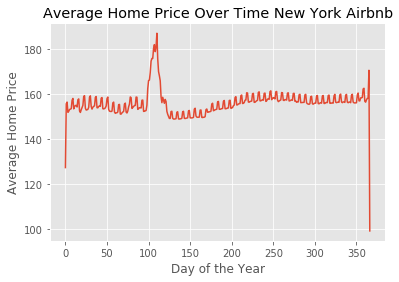

In [159]:
#Analysing the home prices on each single day of the year
plt.plot(seasonal_prices_days['price']);
plt.title('Average Home Price Over Time New York Airbnb');
plt.xlabel('Day of the Year');
plt.ylabel('Average Home Price');

Above plot shows the detail analysis of the average home prices throughout the year.Day 1 is at September-12 2019 and Day 365 is at September-12 2020 in the above graph

<h1><b>3)What are the most common streets in NewYork for Airbnb properties??Does the neighborhood group affect the pricing of the properties?</b></h1> 

In [164]:
#grouping streets according to their frequency and displaying top3 streets
street=listings.groupby('street').count()['id'].reset_index().sort_values(by='id',ascending = False).head(3)
street.rename(columns={'id':'Number of Properties'})

,street,Number of Properties
190,"New York, NY, United States",21451
59,"Brooklyn, NY, United States",18758
225,"Queens, NY, United States",4519


New York Street seems to be the most common place for airbnb properties 

In [161]:
#grouping neighborhood groups according to their price
neighborhood=listings.groupby('neighbourhood_group_cleansed').price.mean().reset_index()

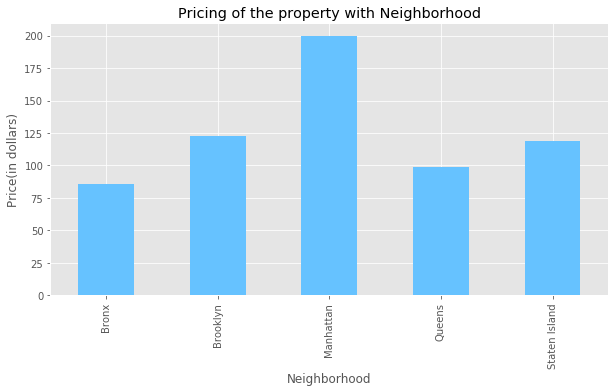

In [166]:
#plotting the data for the above table
neighborhood.plot(kind='bar', 
           x='neighbourhood_group_cleansed',
           y='price',
           color = '#66c2ff', 
           figsize =(10,5), 
           title = "Pricing of the property with Neighborhood", 
           legend = False);
plt.xlabel('Neighborhood');
plt.ylabel('Price(in dollars)');

From the above plot, it seems that pricing of the properties is afffected by the neighbouring groups.Properties having Manhanttan as the neighboring group has the highest average price listed in Airbnb

<h1><b>4)Can we use listing details to predict property prices?What factors determine the price of your home?</b></h1>